# Data Augmentation with Albumentations

https://github.com/albumentations-team/albumentations

In [1]:
import argparse
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.optim as optim
from torch.autograd import Variable
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ToTensor, Compose, RandomAffine
from torchvision import transforms
import torch.nn.functional as F
# import Albumentations package
import albumentations as A

## Task and Plane

In [2]:
task = 'acl'
plane = 'axial'

## Seed

In [3]:
# PyTorch
torch.manual_seed(42)

# CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Numpy
np.random.seed(42)

## 1. Single Image

In [4]:
# Load training data
folder_path = '../../data/train/{0}/'.format(plane)
records = pd.read_csv('../../data/train-{0}.csv'.format(task), header=None, names=['id', 'label'])
records['id'] = records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
paths = [ folder_path + filename + '.npy' for filename in records['id'].tolist()]
labels = records['label'].tolist()

In [5]:
# Get item
_index = 0
array = np.load(paths[_index])
label = labels[_index]

In [6]:
'Number of images on this slice: {}'.format(len(array))

'Number of images on this slice: 44'

In [7]:
image = array[0]

In [8]:
image.shape

(256, 256)

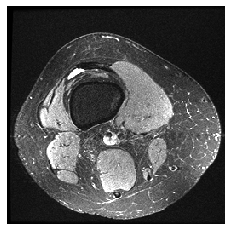

In [9]:
plt.axis("off")
plt.imshow(image, cmap='gray')
image_name = '../../augmentation/image.png'
plt.savefig(image_name)
plt.show()

In [10]:
A.GaussNoise?

In [11]:
# Initialize an augmentation
gaus_noise = A.GaussNoise(var_limit=255, p=1) # gaussian noise

In [12]:
# Apply augmentation
img_gaus = gaus_noise(image = image)

In [13]:
# Access the augmented image by the 'image' key
img_augmented = img_gaus['image']

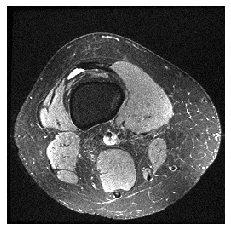

In [14]:
plt.axis("off")
plt.imshow(img_augmented, cmap='gray')
plt.show()

## 2. Data Augmentation Pipeline

In [15]:
image.shape

(256, 256)

In [16]:
# Compose an augmentation pipeline
aug_pipeline = A.Compose(
    [
        A.ShiftScaleRotate(),
        # A.RGBShift(),
        A.Blur(),
        A.GaussNoise()
    ], 
    p=1
)

In [17]:
# Apply augmentations to image and a mask
augmented = aug_pipeline(image = image)

In [18]:
augmented

{'image': array([[23, 21, 19, ..., 16, 21, 22],
        [22, 21, 23, ..., 19, 17, 16],
        [21, 23, 22, ..., 22, 17, 15],
        ...,
        [20, 21, 23, ..., 17, 19, 19],
        [19, 22, 22, ..., 21, 22, 20],
        [22, 21, 20, ..., 20, 23, 22]], dtype=uint8)}

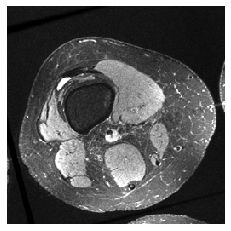

In [19]:
plt.axis("off")
plt.imshow(augmented['image'], cmap='gray')
plt.show()

In [20]:
# Compose a complex augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        A.OneOf(
            [
                # apply one of transforms to 50% images
                A.ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                A.GridDistortion(),
                A.OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
            ],
            p = 0.5
        )
    ],
    p = 1
)

In [21]:
# Apply pipeline to sample image
images_aug = np.array([augmentation_pipeline(image = image)['image'] for _ in range(16)])

In [22]:
def plot_images(images_array, image_name, figsize=(12, 15)):
    
    print('Shape of the array: {}'.format(images_array.shape))
    num_images, _, _ = images_array.shape
    print('Number of images: {}'.format(num_images))

    cols = 5
    rows = num_images // cols
    if num_images % cols > 0: rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, dpi=100)
    axes_flattened = axes.flatten()

    for i in range(rows * cols):
        if i < num_images:
            image = images_array[i]
            axes_flattened[i].imshow(image, cmap='gray')
            axes_flattened[i].set_title('Image {}'.format(i))
        axes_flattened[i].axis('off')

    fig.tight_layout()
    
    plt.savefig('../../figures/{}'.format(image_name), bbox_inches='tight')
    
    plt.show()

Shape of the array: (16, 256, 256)
Number of images: 16


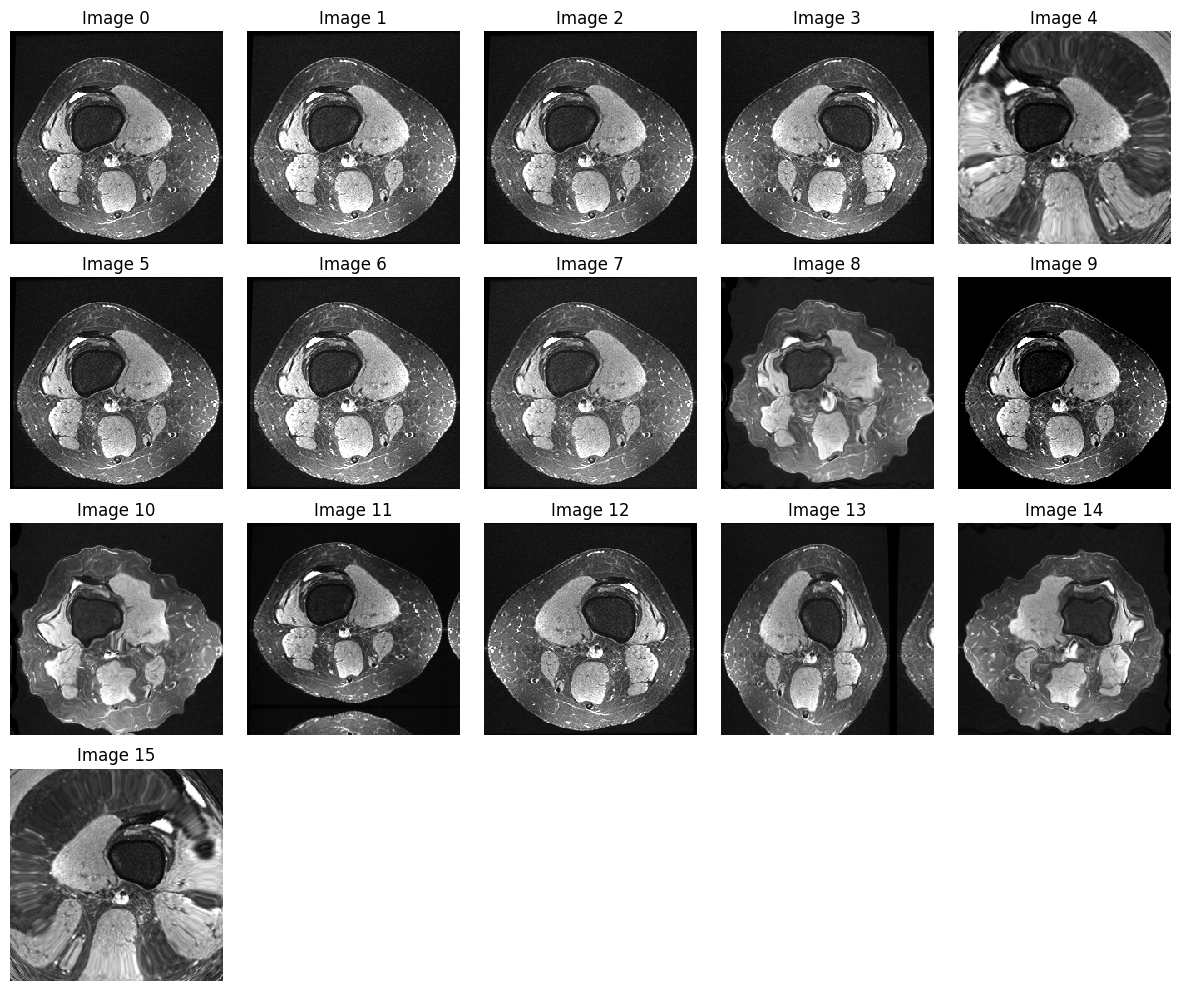

In [23]:
plot_images(images_aug, 'augmentation_III_albumentations_one_image.png', figsize=(12, 10))

## 3. Integration with Pytorch

In [24]:
# Import pytorch utilities from albumentations
from albumentations.pytorch import ToTensor

# Define the augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
        
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)

In [25]:
import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0)
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

**Different transformations to the slices**

In [26]:
# Why 3 channels?
# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
# https://pytorch.org/docs/stable/torchvision/models.html
CHANNELS = 3

# Import PyTorch
import torchvision.transforms.functional as TF

class MRDataset(Dataset):

    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        
        print('[DATALOADER] __init__ task: {}, plane: {}, train: {}'.format(task, plane, train))

        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
        self.paths = [ self.folder_path + filename + '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights
    
    def __len__(self):

        print('[DATALOADER] __len__')
        
        return len(self.paths)

    def __getitem__(self, index):

        print('[DATALOADER] __getitem__ index: {}'.format(index))

        array = np.load(self.paths[index])
        print('Before transformation: {}'.format(array.shape))
        
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:  
            # one by one
            array = np.stack([ self.transform(image=array[i])['image'] for i in range(len(array)) ], axis=0)
            array = np.stack((array,) * CHANNELS, axis=1)
        else:
            array = np.stack((array,) * CHANNELS, axis=1)
            array = torch.FloatTensor(array)
            
        print('After transformation: {}'.format(array.shape))

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [27]:
def train_model(model, train_loader, epoch, num_epochs, optimizer):
    
    print('[TRAIN] Train model')

    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        
        optimizer.zero_grad()

        # Copy to CUDA device
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        # Forward pass
        prediction = model.forward(image.float())
        loss = F.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])

        # Backward and Optimize
        loss.backward()
        optimizer.step()

        # Prediction
        y_pred = torch.sigmoid(prediction).item()
        y_true = int(label.item())

        y_preds.append(y_pred)
        y_trues.append(y_true)

        # Metric
        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        # Loss
        loss_value = loss.item()
        losses.append(loss_value)
        
        print('{}. Train Loss: {:.4f},  Train AUC: {:.4f}, Label: {}, Weight: {:.4f}, Prediction: {:.4f}'.format(
            i + 1, loss_value, auc, y_true, weight.item(), y_pred))

        # Show just the first 4 patients
        if i == 4:
            return

In [28]:
mrnet = MRNet()
mrnet = mrnet.cuda()

In [29]:
epoch = 0
iteration_change_loss = 0
patience = 5
log_every = 20
num_epochs = 10

In [30]:
# Adam optimizer as well as a learning rate scheduler
optimizer = optim.Adam(mrnet.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)

In [31]:
# AUGMENTATION
train_dataset = MRDataset('../../data/', task, plane, transform=augmentation_pipeline, train=True)

[DATALOADER] __init__ task: acl, plane: axial, train: True


In [32]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False)

[DATALOADER] __len__
[DATALOADER] __len__


In [33]:
# Load one image
for batch_idx, data in enumerate(train_loader):

    array, label, weight = data

    print('## Batch ID: {}, label: {}, weight: {}'.format(batch_idx, label.item(), weight.item()))
    print('Shape of the array: {}'.format(array.shape))

    break

[DATALOADER] __len__
[DATALOADER] __getitem__ index: 176
Before transformation: (36, 256, 256)
After transformation: (36, 3, 256, 256)
## Batch ID: 0, label: 1.0, weight: 4.432692527770996
Shape of the array: torch.Size([1, 36, 3, 256, 256])


In [34]:
def plot_slices(images_array, image_name, figsize=(12, 15)):
    
    print(images_array.shape)
    _, num_slices, _, _, _ = images_array.shape
    print('Number of slices: {}'.format(num_slices))

    cols = 5
    rows = num_slices // cols
    if num_slices % cols > 0: rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize, dpi=100)
    axes_flattened = axes.flatten()

    for i in range(rows * cols):
        if i < num_slices:
            slice_array = images_array[0][i][0]
            axes_flattened[i].imshow(slice_array, cmap='gray')
            axes_flattened[i].set_title('Slice {}'.format(i))
        axes_flattened[i].axis('off')

    fig.tight_layout()
    
    plt.savefig('../../figures/{}'.format(image_name), bbox_inches='tight')
    
    plt.show()

torch.Size([1, 36, 3, 256, 256])
Number of slices: 36


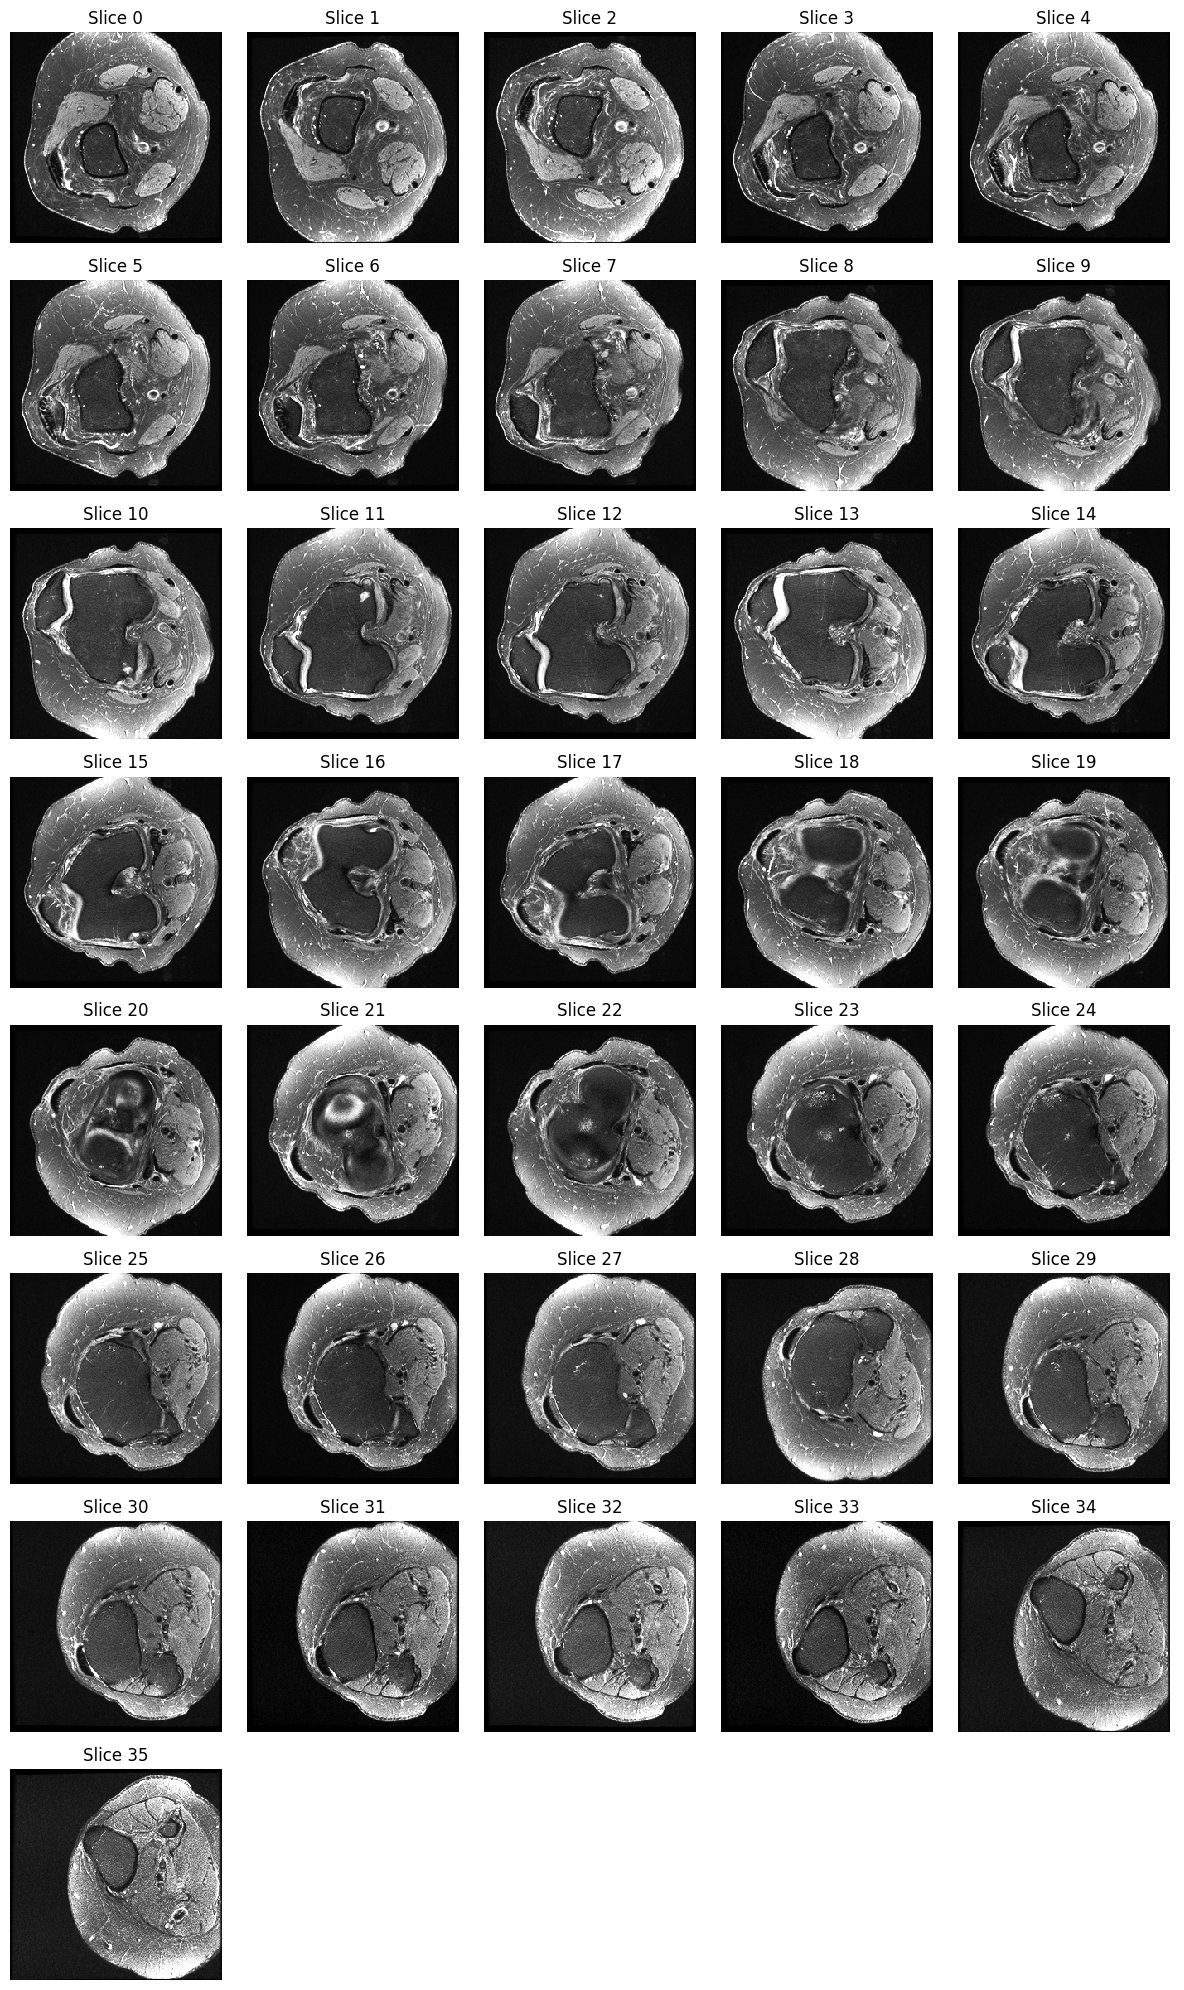

In [35]:
plot_slices(array,  'augmentation_III_albumentations_slices_different_transformations.png', figsize=(12, 20))

**Same transformation**

In [36]:
transformations = [
    A.VerticalFlip(p = 1)
]

In [37]:
CHANNELS = 3

# Import PyTorch
import torchvision.transforms.functional as TF

class MRDataset(Dataset):

    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        
        print('[DATALOADER] __init__ task: {}, plane: {}, train: {}'.format(task, plane, train))

        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map( lambda i: '0' * (4 - len(str(i))) + str(i) )
        self.paths = [ self.folder_path + filename + '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights
    
    def __len__(self):

        print('[DATALOADER] __len__')
        
        return len(self.paths)

    def __getitem__(self, index):

        print('[DATALOADER] __getitem__ index: {}'.format(index))

        array = np.load(self.paths[index])
        print('Before transformation: {}'.format(array.shape))
        
        label = self.labels[index]
        label = torch.FloatTensor([label])

        if self.transform:  
            # one by one
            # array = np.stack([ self.transform(image=array[i])['image'] for i in range(len(array)) ], axis=0)
            
            # same transformation to all images
            targets = {}
            for i in range(len(array[1:])):
                targets['image' + str(i + 1)] = 'image'

            # transformation
            custom_augment = A.Compose(
                transformations, 
                p = 1, 
                additional_targets=targets)
            
            # dictionary of images
            d = {}
            d['image'] = array[0]
            for i in range(len(array[1:])):
                d['image' + str(i + 1)] = array[i + 1]
            
            # custom transform
            out = custom_augment(**d)
            
            # grab them
            out_array = []
            out_array.append(out['image'])
            for i in range(len(array[1:])):
                out_array.append(out['image' + str(i + 1)])
            
            array = np.stack((out_array,) * CHANNELS, axis=1)
        else:
            array = np.stack((array,) * CHANNELS, axis=1)
            array = torch.FloatTensor(array)
            
        print('After transformation: {}'.format(array.shape))

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight

In [38]:
# AUGMENTATION
train_dataset = MRDataset('../../data/', task, plane, transform=True, train=True)

[DATALOADER] __init__ task: acl, plane: axial, train: True


In [39]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False)

[DATALOADER] __len__
[DATALOADER] __len__


In [40]:
# Load one image
for batch_idx, data in enumerate(train_loader):

    array, label, weight = data

    print('## Batch ID: {}, label: {}, weight: {}'.format(batch_idx, label.item(), weight.item()))
    print('Shape of the array: {}'.format(array.shape))

    break

[DATALOADER] __len__
[DATALOADER] __getitem__ index: 150
Before transformation: (23, 256, 256)
After transformation: (23, 3, 256, 256)
## Batch ID: 0, label: 1.0, weight: 4.432692527770996
Shape of the array: torch.Size([1, 23, 3, 256, 256])


torch.Size([1, 23, 3, 256, 256])
Number of slices: 23


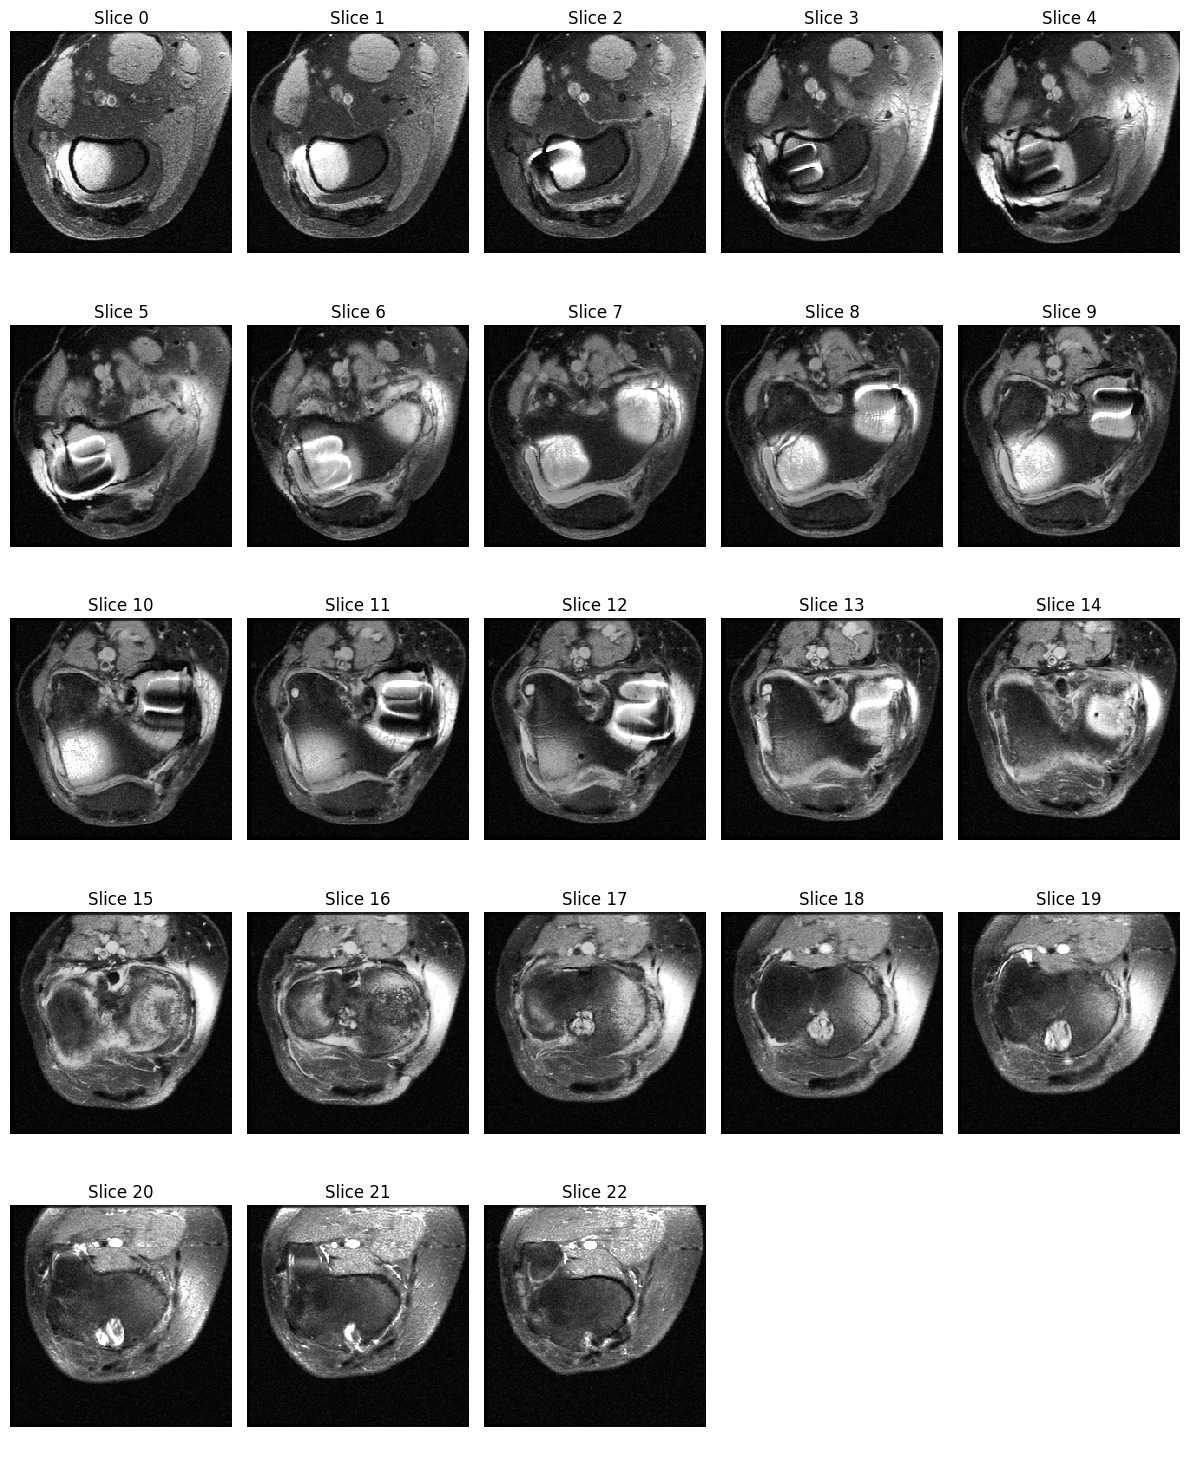

In [41]:
plot_slices(array,  'augmentation_III_albumentations_slices_same_transformations.png', figsize=(12, 15))